# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-380ulzn4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-380ulzn4
  Resolved https://github.com/openai/CLIP.git to commit 40f5484c1c74edd83cb9cf687c6ab92b28d8b656
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import torch
import clip
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
print("Torch version:", torch.__version__)

# assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 1.10.2+cu102


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14']

In [4]:
model, preprocess = clip.load("ViT-B/16")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 149,620,737
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [6]:
type(preprocess), preprocess

(torchvision.transforms.transforms.Compose,
 Compose(
     Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
     CenterCrop(size=(224, 224))
     <function _convert_image_to_rgb at 0x7f9620821550>
     ToTensor()
     Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
 ))

In [7]:
preprocess.transforms[-1].std

(0.26862954, 0.26130258, 0.27577711)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [ ]:
clip.tokenize("Yifei Ming")

tensor([[49406,  5826, 34217,  2107, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [28]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

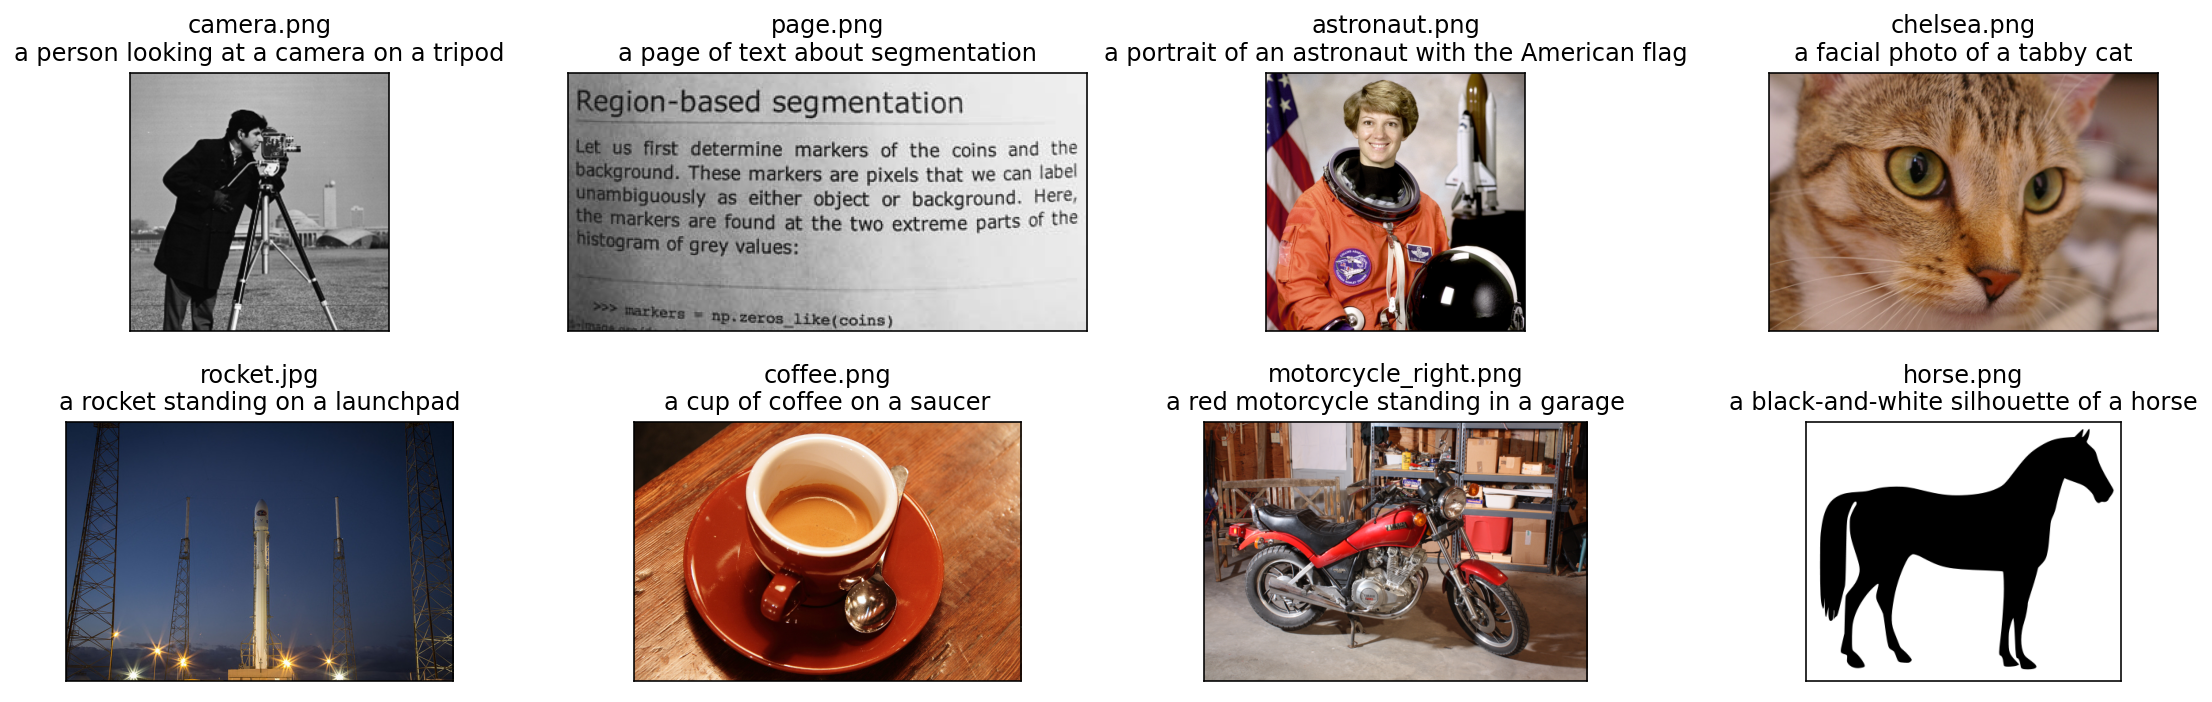

In [4]:
original_images = []
images = []
texts = []
file_names = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])
    file_names.append(filename)

plt.tight_layout()


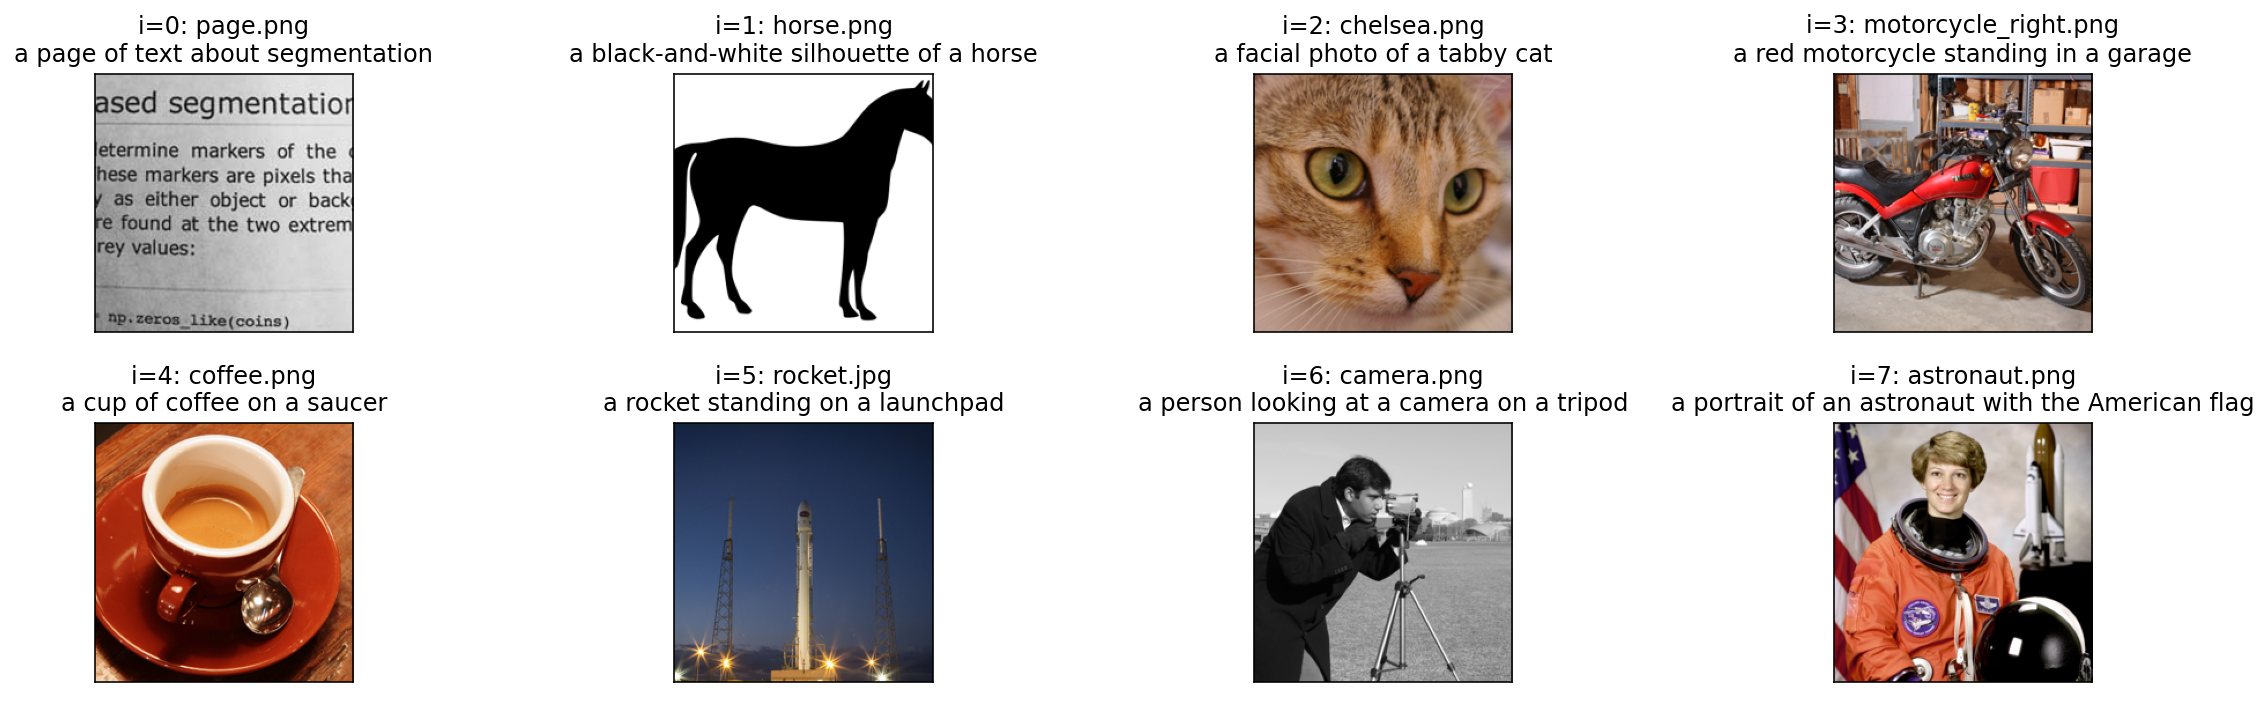

In [ ]:
#recover and display images from tensors
plt.figure(figsize=(16, 5))

for i, image in enumerate(images):  
    plt.subplot(2, 4, i + 1)
    mean = torch.tensor(preprocess.transforms[-1].mean)
    std = torch.tensor(preprocess.transforms[-1].std)
    recovered_img = image*std[:,None, None] + mean[:, None, None]
    plt.imshow(np.transpose(recovered_img.numpy(), (1,2,0)))
    plt.title(f"i={i}: {file_names[i]}\n{texts[i]}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

In [ ]:
type(np.stack(images)[0]) #list of tensors changed to a np array with dim (8,3,224,224)

numpy.ndarray

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [5]:
image_input = torch.tensor(np.stack(images)).cuda() # get a batch of imgs
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda() 

In [6]:
print(image_input.shape, text_tokens.shape)

torch.Size([8, 3, 224, 224]) torch.Size([8, 77])


In [7]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [ ]:
print(image_features.shape, text_features.shape)

torch.Size([8, 512]) torch.Size([8, 512])


In [ ]:
print(image_features.norm(dim = -1),text_features.norm(dim = -1))

tensor([ 8.7300, 11.1026, 11.4356, 10.4241, 11.5236, 10.7176, 11.1885,  9.2506],
       device='cuda:0') tensor([10.7678,  7.8758,  8.2010,  8.1512,  9.1885,  8.9703,  9.4563,  8.5778],
       device='cuda:0')


## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

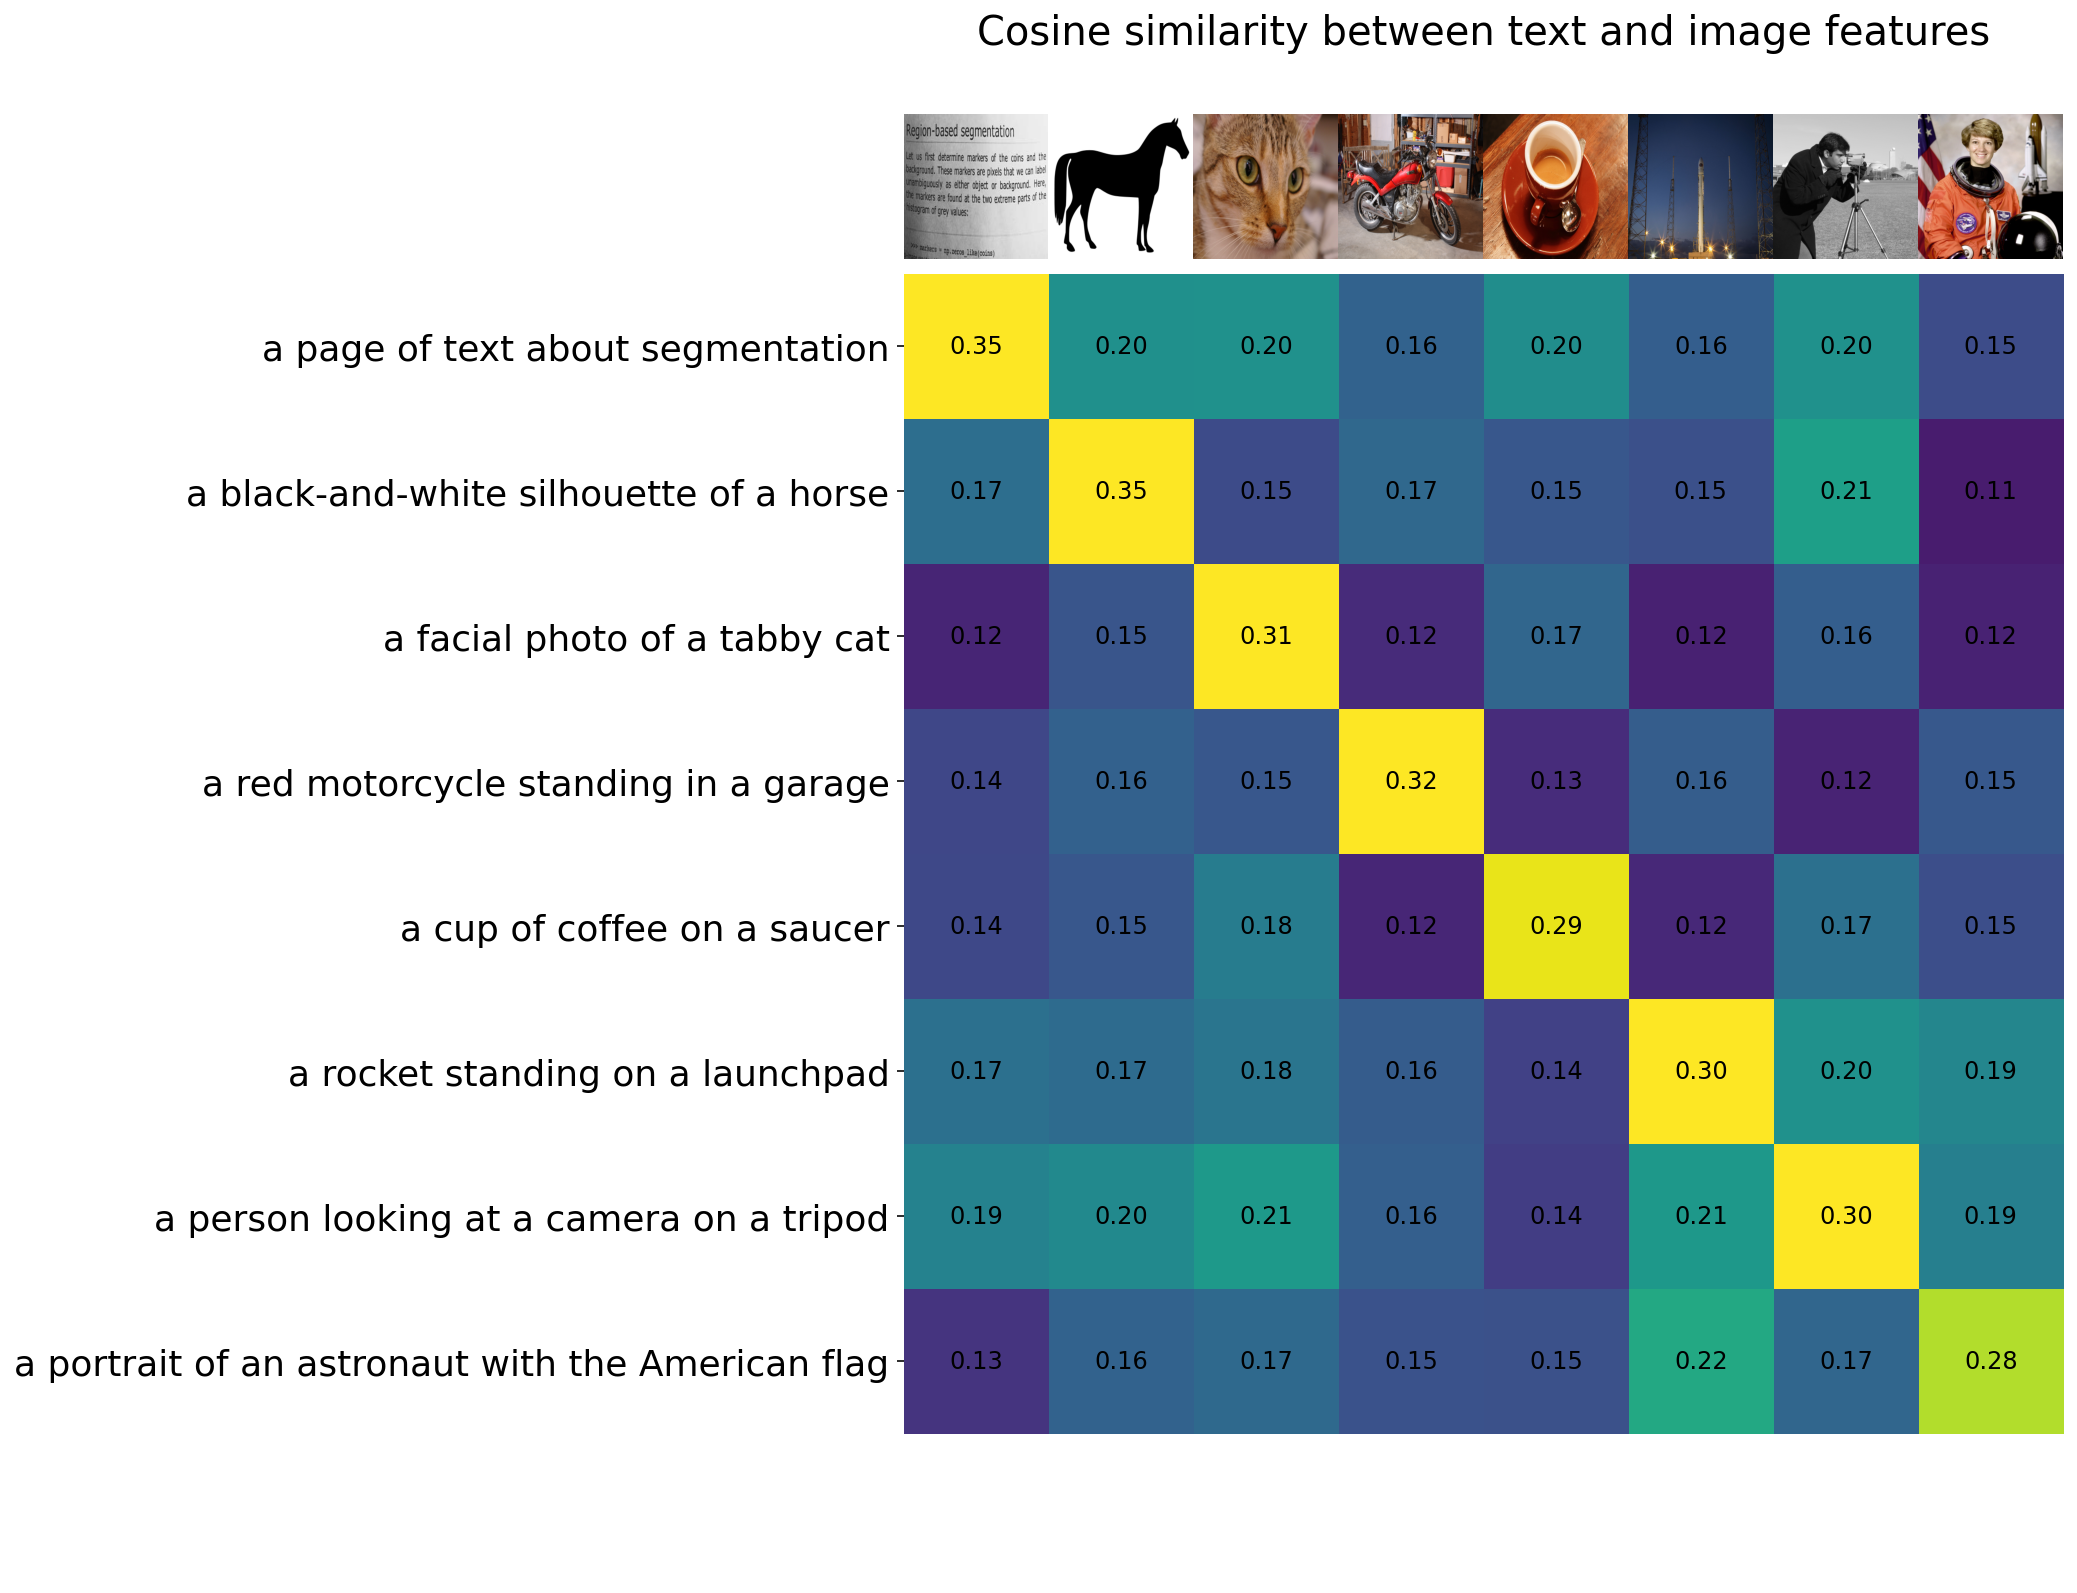

In [ ]:
count = len(descriptions)

def plot_similarity(count, original_images,texts):
    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    # plt.colorbar()
    plt.yticks(range(count), texts, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(original_images):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower") # (left, right, bottom, top)
    for x in range(similarity.shape[1]): 
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
      plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])
    # plt.ylim([-2,count + 0.5])
    plt.title("Cosine similarity between text and image features", size=20)
plot_similarity(count, original_images,texts)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [79]:
from torchvision.datasets import CIFAR10
from collections import defaultdict

dataset = CIFAR10(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

classwise_count = defaultdict(int)
indices = []
for i, label in enumerate(dataset.targets): 
    if classwise_count[label] < 1:
        indices.append(i)
        classwise_count[label] += 1

sorted_idx = np.array(indices)[np.argsort(np.array(dataset.targets)[indices])]
# indices = np.array(dataset.targets)[sorted_idx]
subset = torch.utils.data.Subset(dataset, sorted_idx)   
loader = torch.utils.data.DataLoader(subset,
                batch_size=1, shuffle=False)
image_features = []
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(loader):
        image_feature = model.encode_image(images.cuda()).float()
        image_feature /= image_feature.norm(dim=-1, keepdim=True)
        image_features.append(image_feature.cpu())
image_features = torch.cat(image_features)


Files already downloaded and verified


In [61]:
original_images = []

MEAN =  torch.tensor(preprocess.transforms[-1].mean)
STD = torch.tensor(preprocess.transforms[-1].std)

for image, label in loader:
    image = image[0] * STD[:, None, None] + MEAN[:, None, None]
    original_images.append(image.numpy().transpose(1, 2, 0))
    

In [9]:
# print(os.path.expanduser("~/.cache"))
# print(os.environ['HOME'])

/u/a/l/alvinming/.cache
/u/a/l/alvinming


In [69]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar10.classes] # 100 sentences in total
text_tokens = clip.tokenize(text_descriptions).cuda()

In [82]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float().cpu()
    text_features /= text_features.norm(dim=-1, keepdim=True) # cannot remove keepdim = True
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.topk(5, dim=-1)
similarity = text_features.numpy() @ image_features.numpy().T

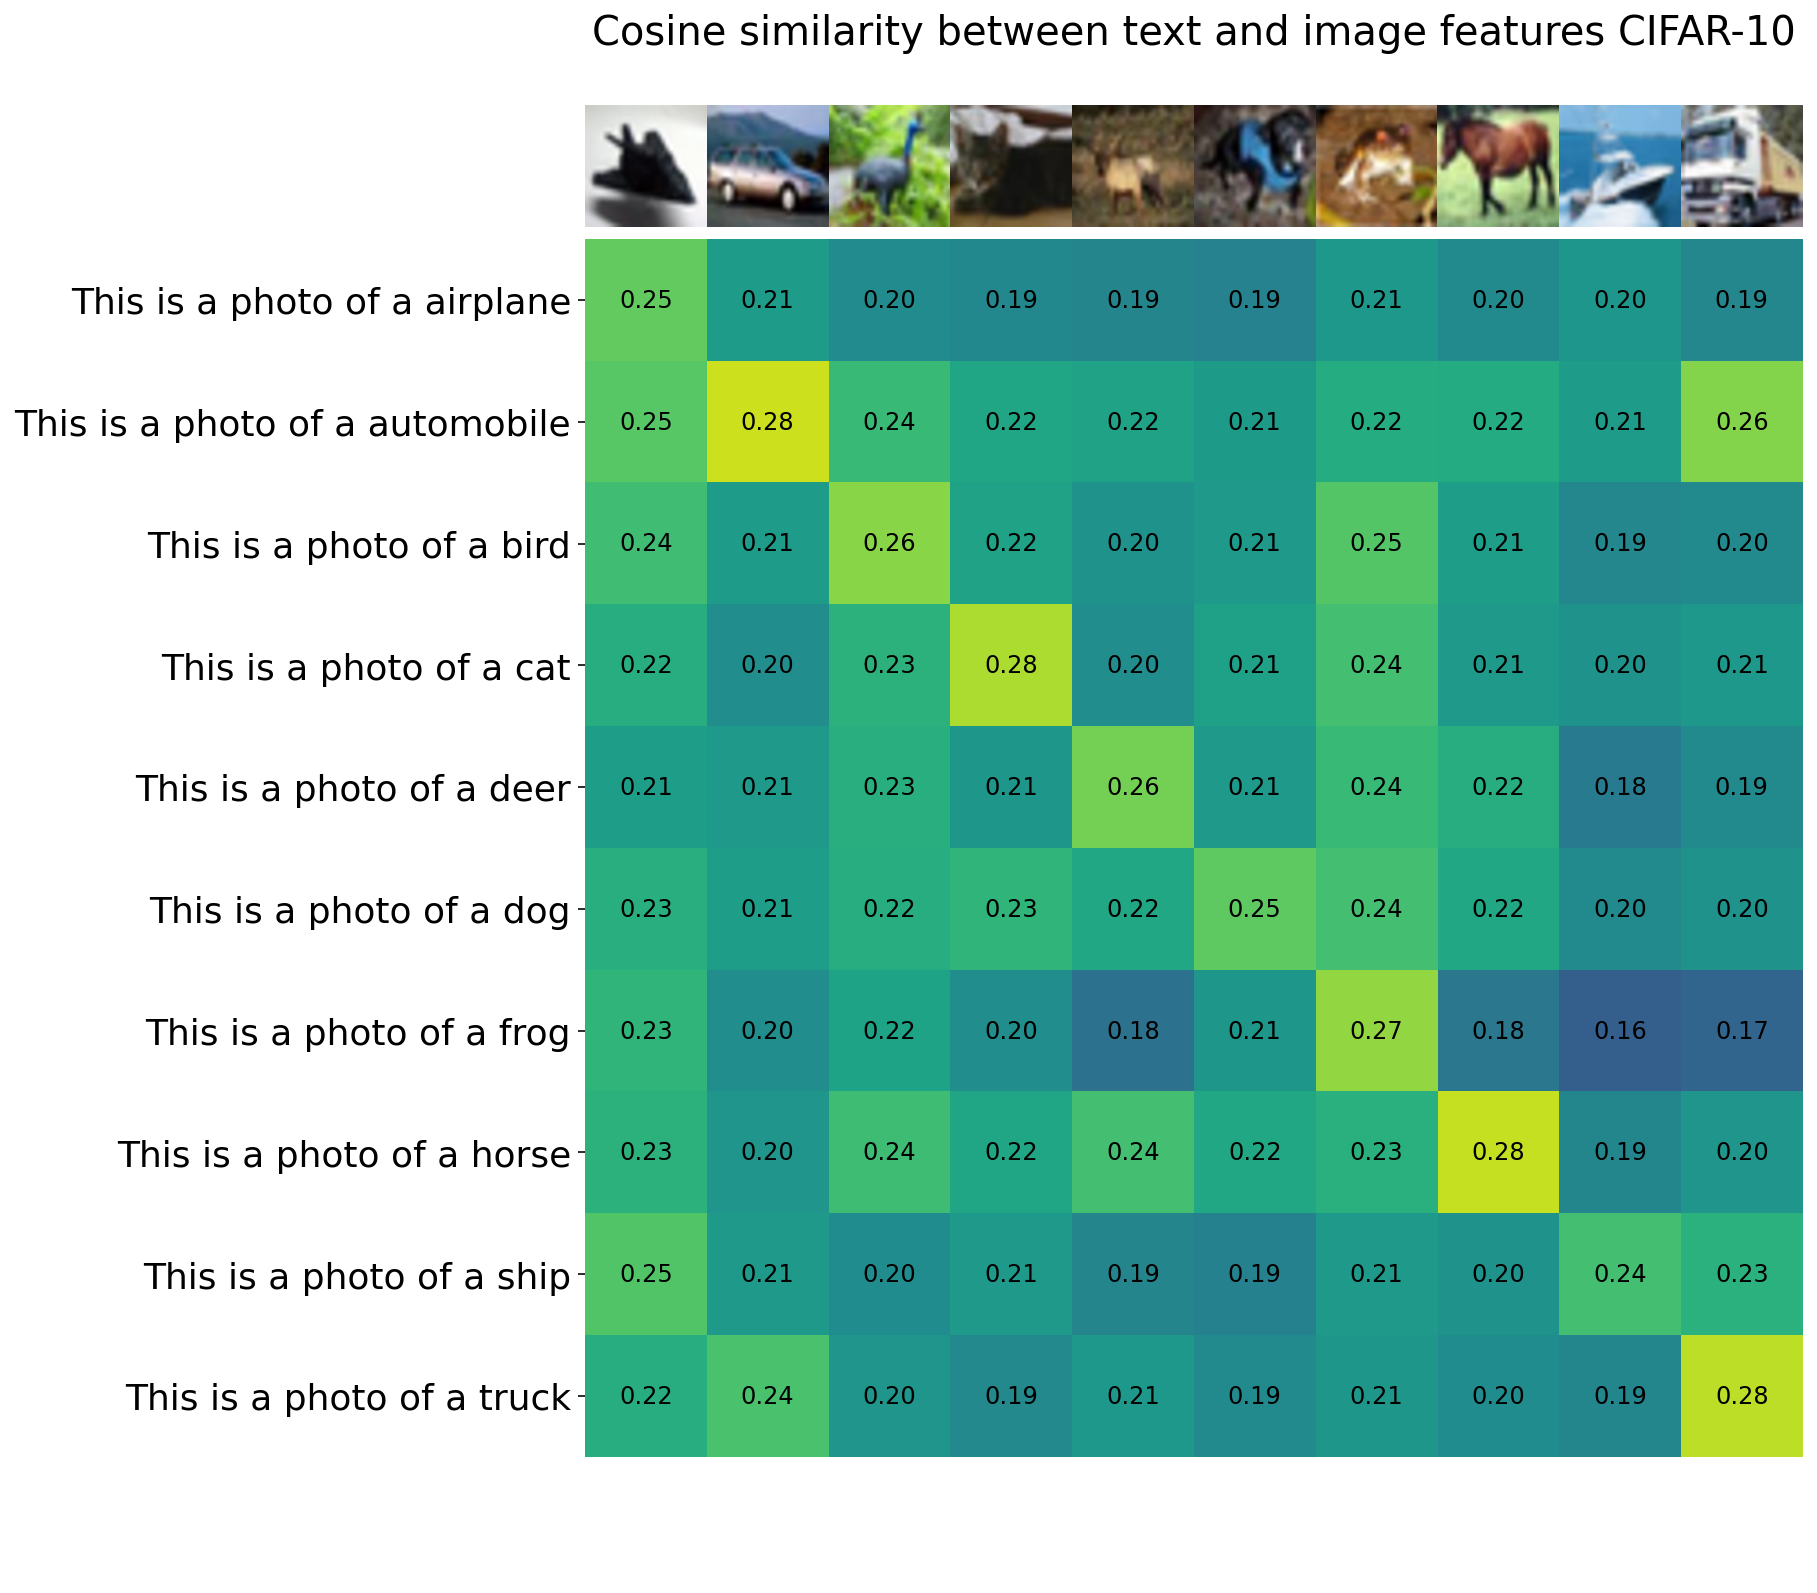

In [84]:
def plot_similarity(original_images,texts):
    count = len(text_descriptions)
    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    # plt.colorbar()
    plt.yticks(range(count), texts, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(original_images):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower") # (left, right, bottom, top)
    for x in range(similarity.shape[1]): 
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
      plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])
    # plt.ylim([-2,count + 0.5])
    plt.title("Cosine similarity between text and image features CIFAR-10", size=20)
    
plot_similarity( original_images,text_descriptions)


In [29]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

NameError: name 'original_images' is not defined

<Figure size 1152x1152 with 0 Axes>

In [35]:
def read_file(file_path, root = 'corpus'):
    corpus = []
    with open(os.path.join(root, file_path)) as f:
        for line in f:
            corpus.append(line[:-1])
    return corpus

random_test = read_file('wiki_en_full.txt')
random_test = np.random.choice(random_test, size = 2000, replace = False)

truth = ['newspaper', 'cat', 'horse', 'woman', 'rocket', 'man', 'cup', 'camera', 'astronaut', 'paper', 'text']
random_test.extend(truth)
print(len(random_test))
text_descriptions = [f"This is a photo of a {label}" for label in random_test] # 100 sentences in total
text_tokens = clip.tokenize(text_descriptions).cuda()
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True) # cannot remove keepdim = True

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U62'), dtype('<U9')) -> None

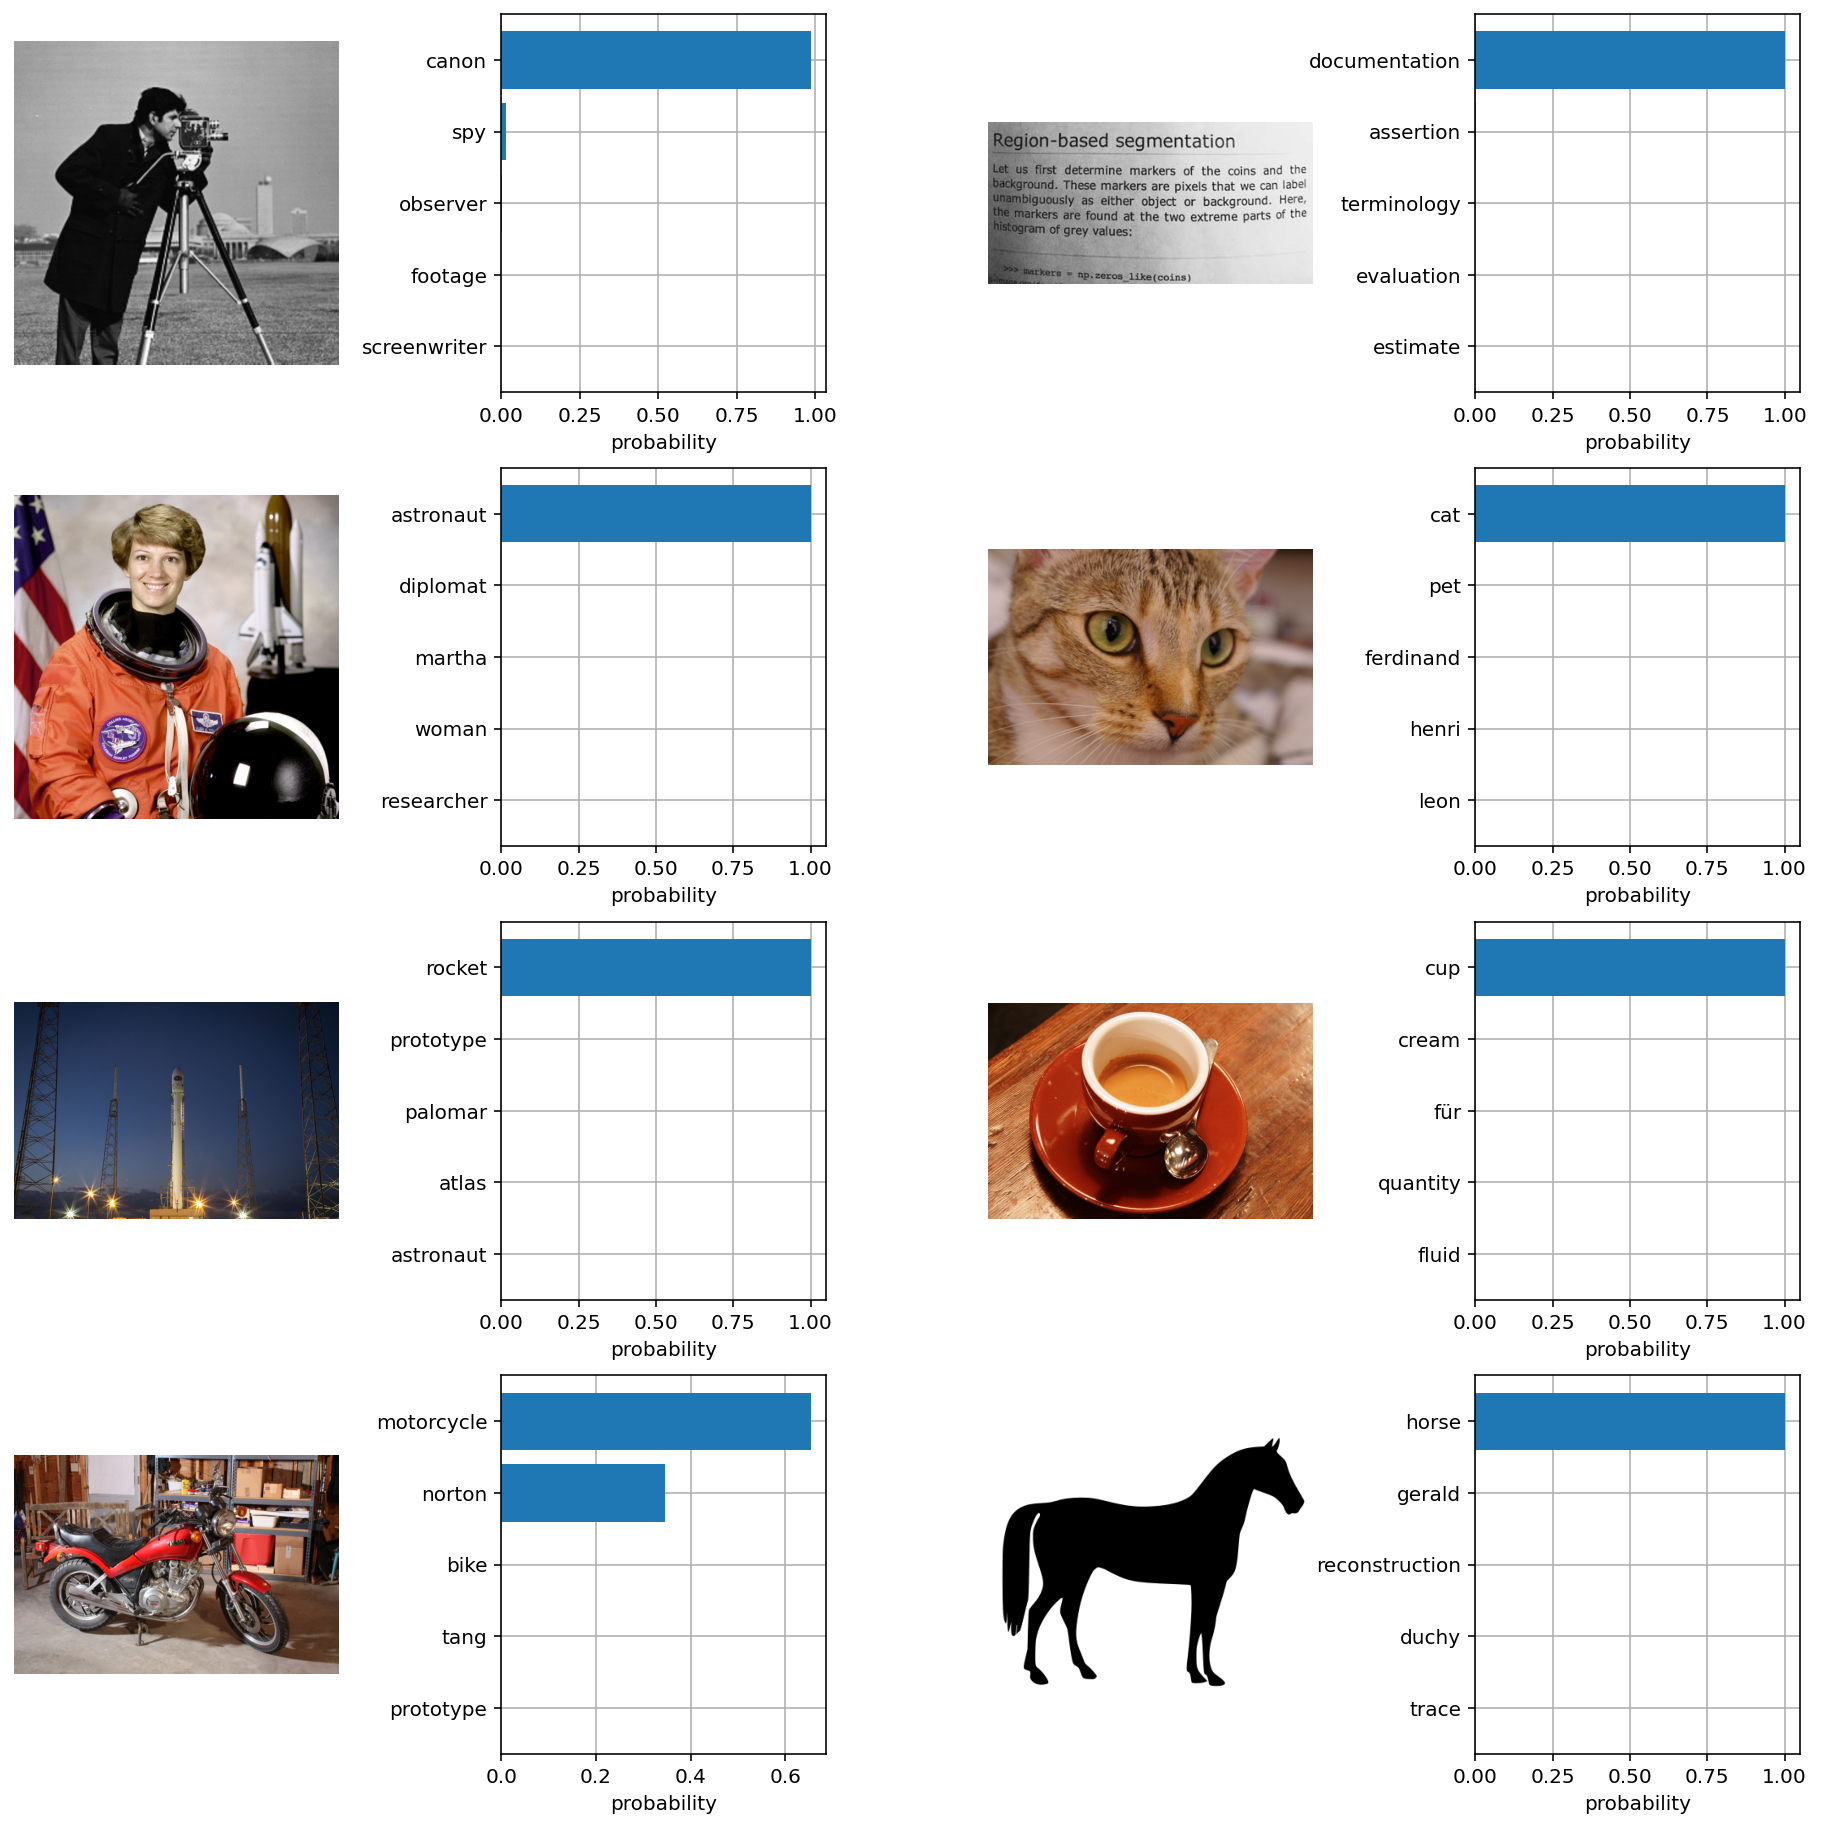

In [30]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [random_test[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

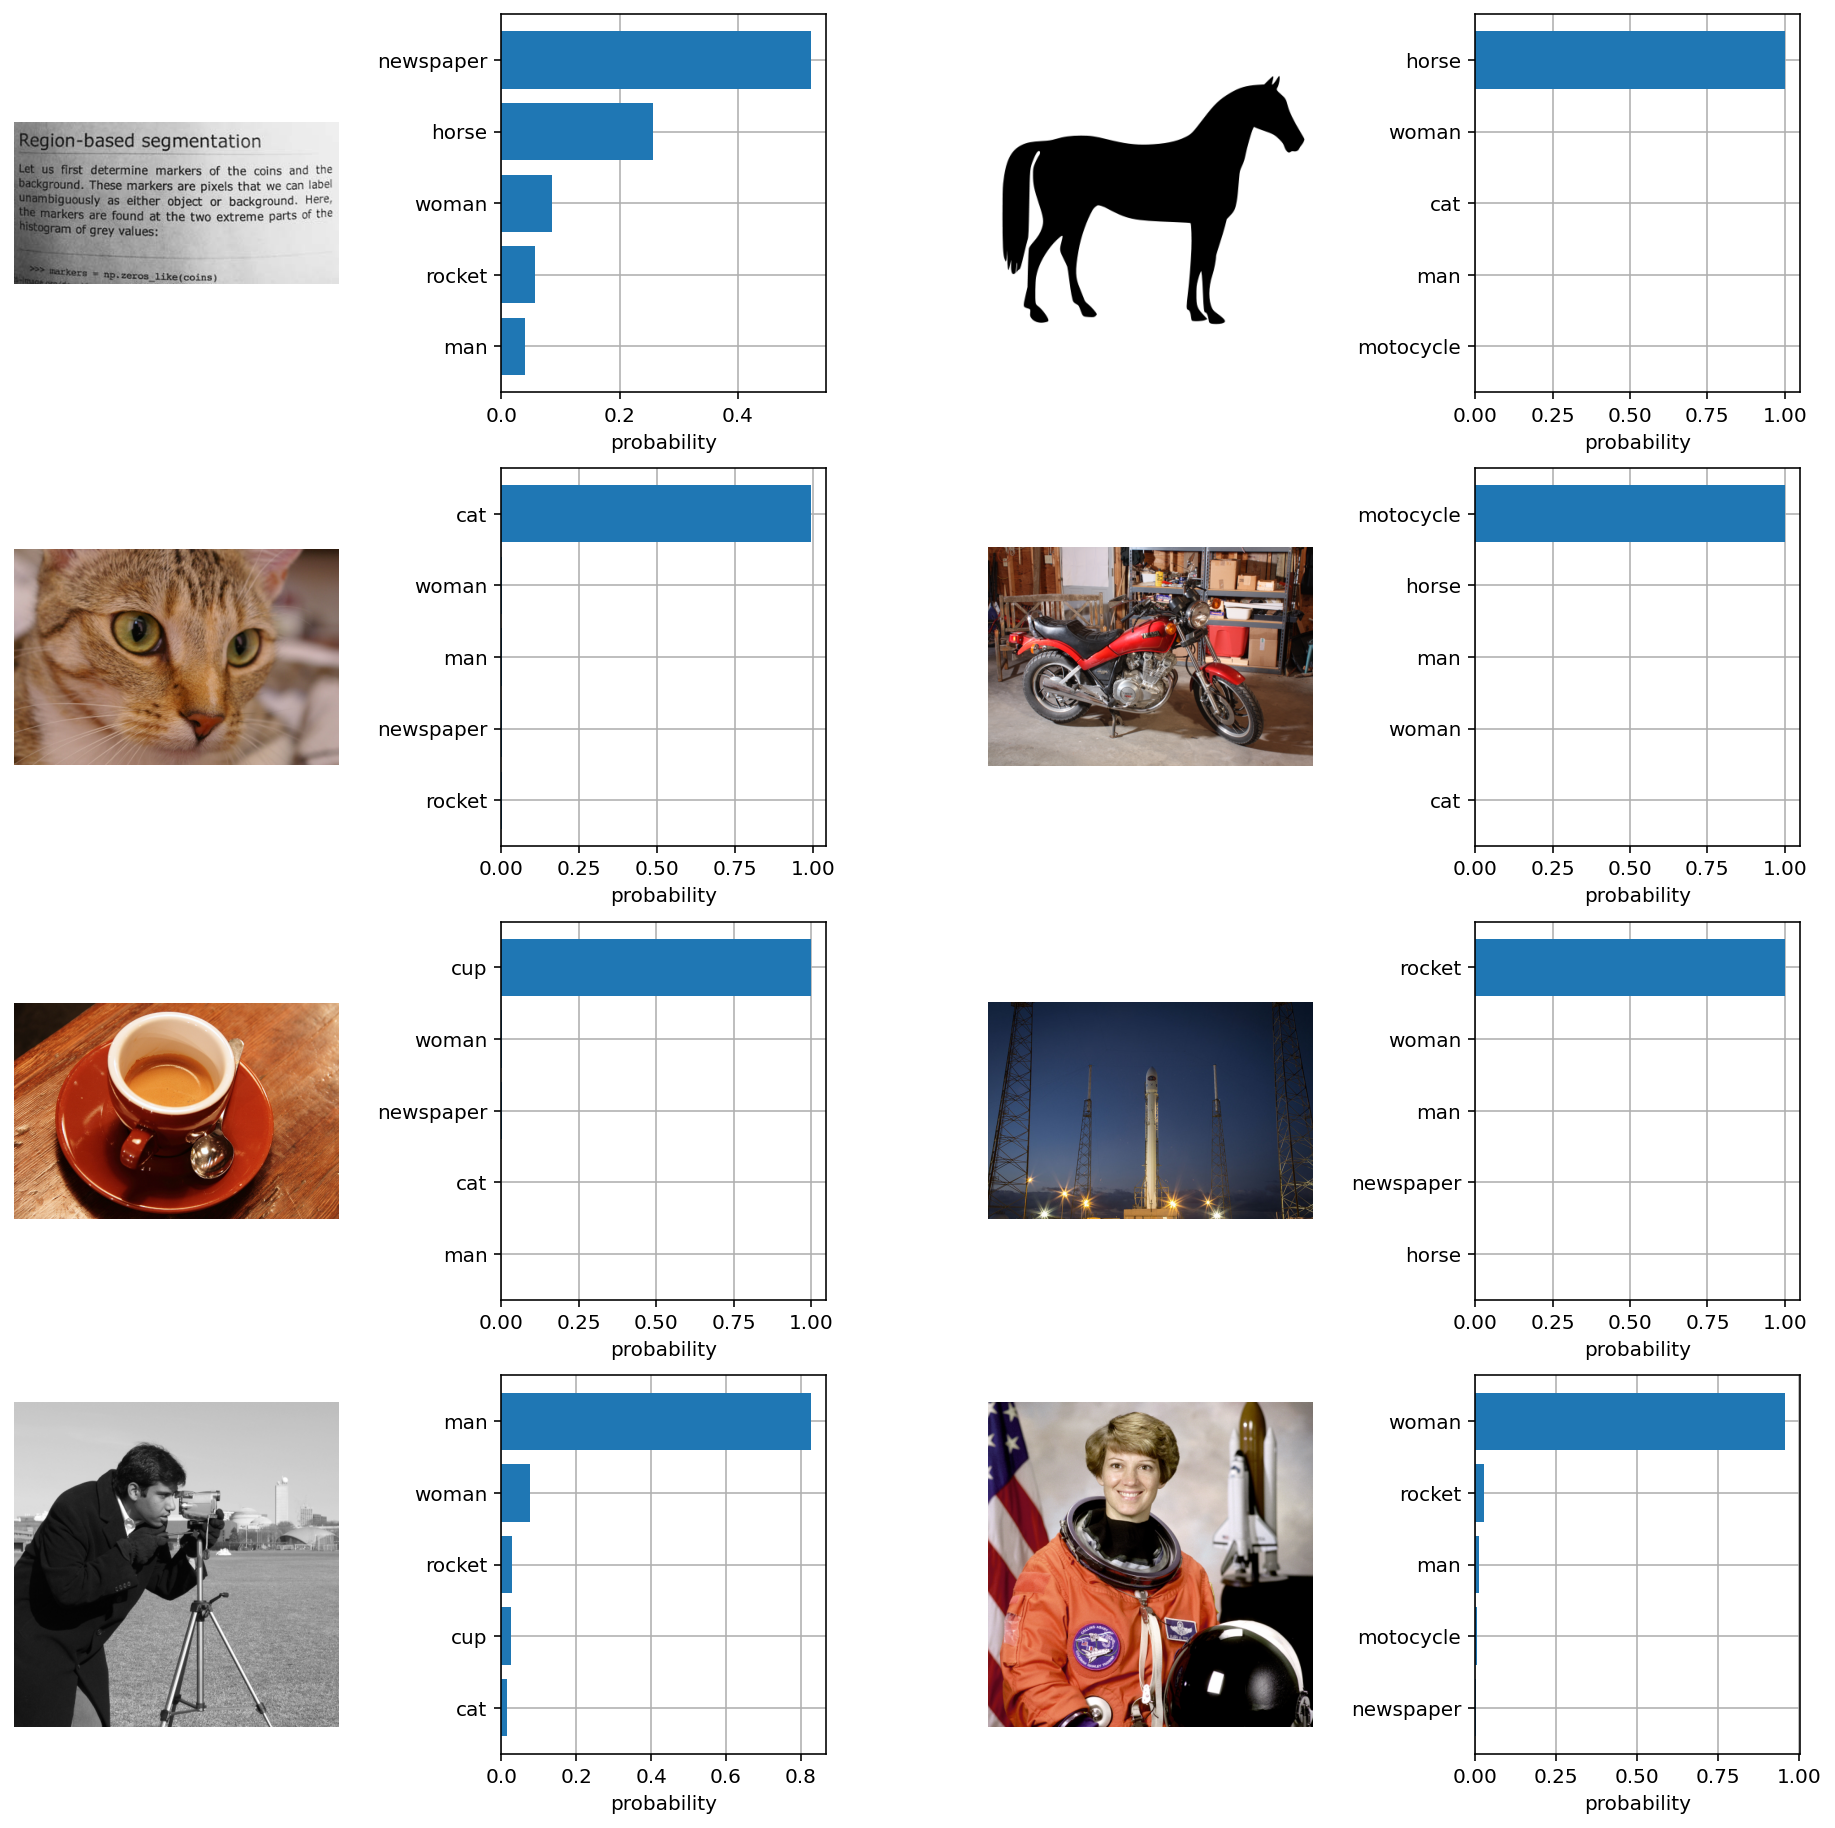

In [ ]:
random_test = ['newspaper', 'horse', 'cat','motocycle', 'cup','rocket', 'man', 'woman']

text_descriptions = [f"This is a photo of a {label}" for label in random_test] # 100 sentences in total
text_tokens = clip.tokenize(text_descriptions).cuda()
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True) # cannot remove keepdim = True
similarity = image_features @ text_features.T
text_probs = (100.0 * similarity).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [random_test[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

[[0.19061635 0.19447602 0.21367696 0.17199364 0.2065914  0.196862
  0.20274399 0.16764775]
 [0.18346503 0.3036913  0.20926493 0.20491758 0.20011286 0.18444626
  0.20394887 0.16643749]
 [0.14937638 0.2155169  0.27885634 0.18126069 0.20304014 0.16756833
  0.20471057 0.15254675]
 [0.13957678 0.20105253 0.19031982 0.28445643 0.17926106 0.16343555
  0.19211178 0.17811511]
 [0.16111597 0.19919616 0.20036824 0.16906045 0.28407815 0.17031658
  0.20969181 0.14775267]
 [0.1682992  0.19603398 0.21085227 0.177733   0.18449567 0.2809069
  0.2107949  0.1976012 ]
 [0.16503577 0.21298859 0.2140671  0.18855219 0.20296507 0.20121041
  0.24471578 0.18885094]
 [0.17252494 0.21703629 0.22222818 0.18599115 0.20894702 0.20351605
  0.22074735 0.2334799 ]]


Text(0.5, 1.0, 'Cosine similarity between text and image features')

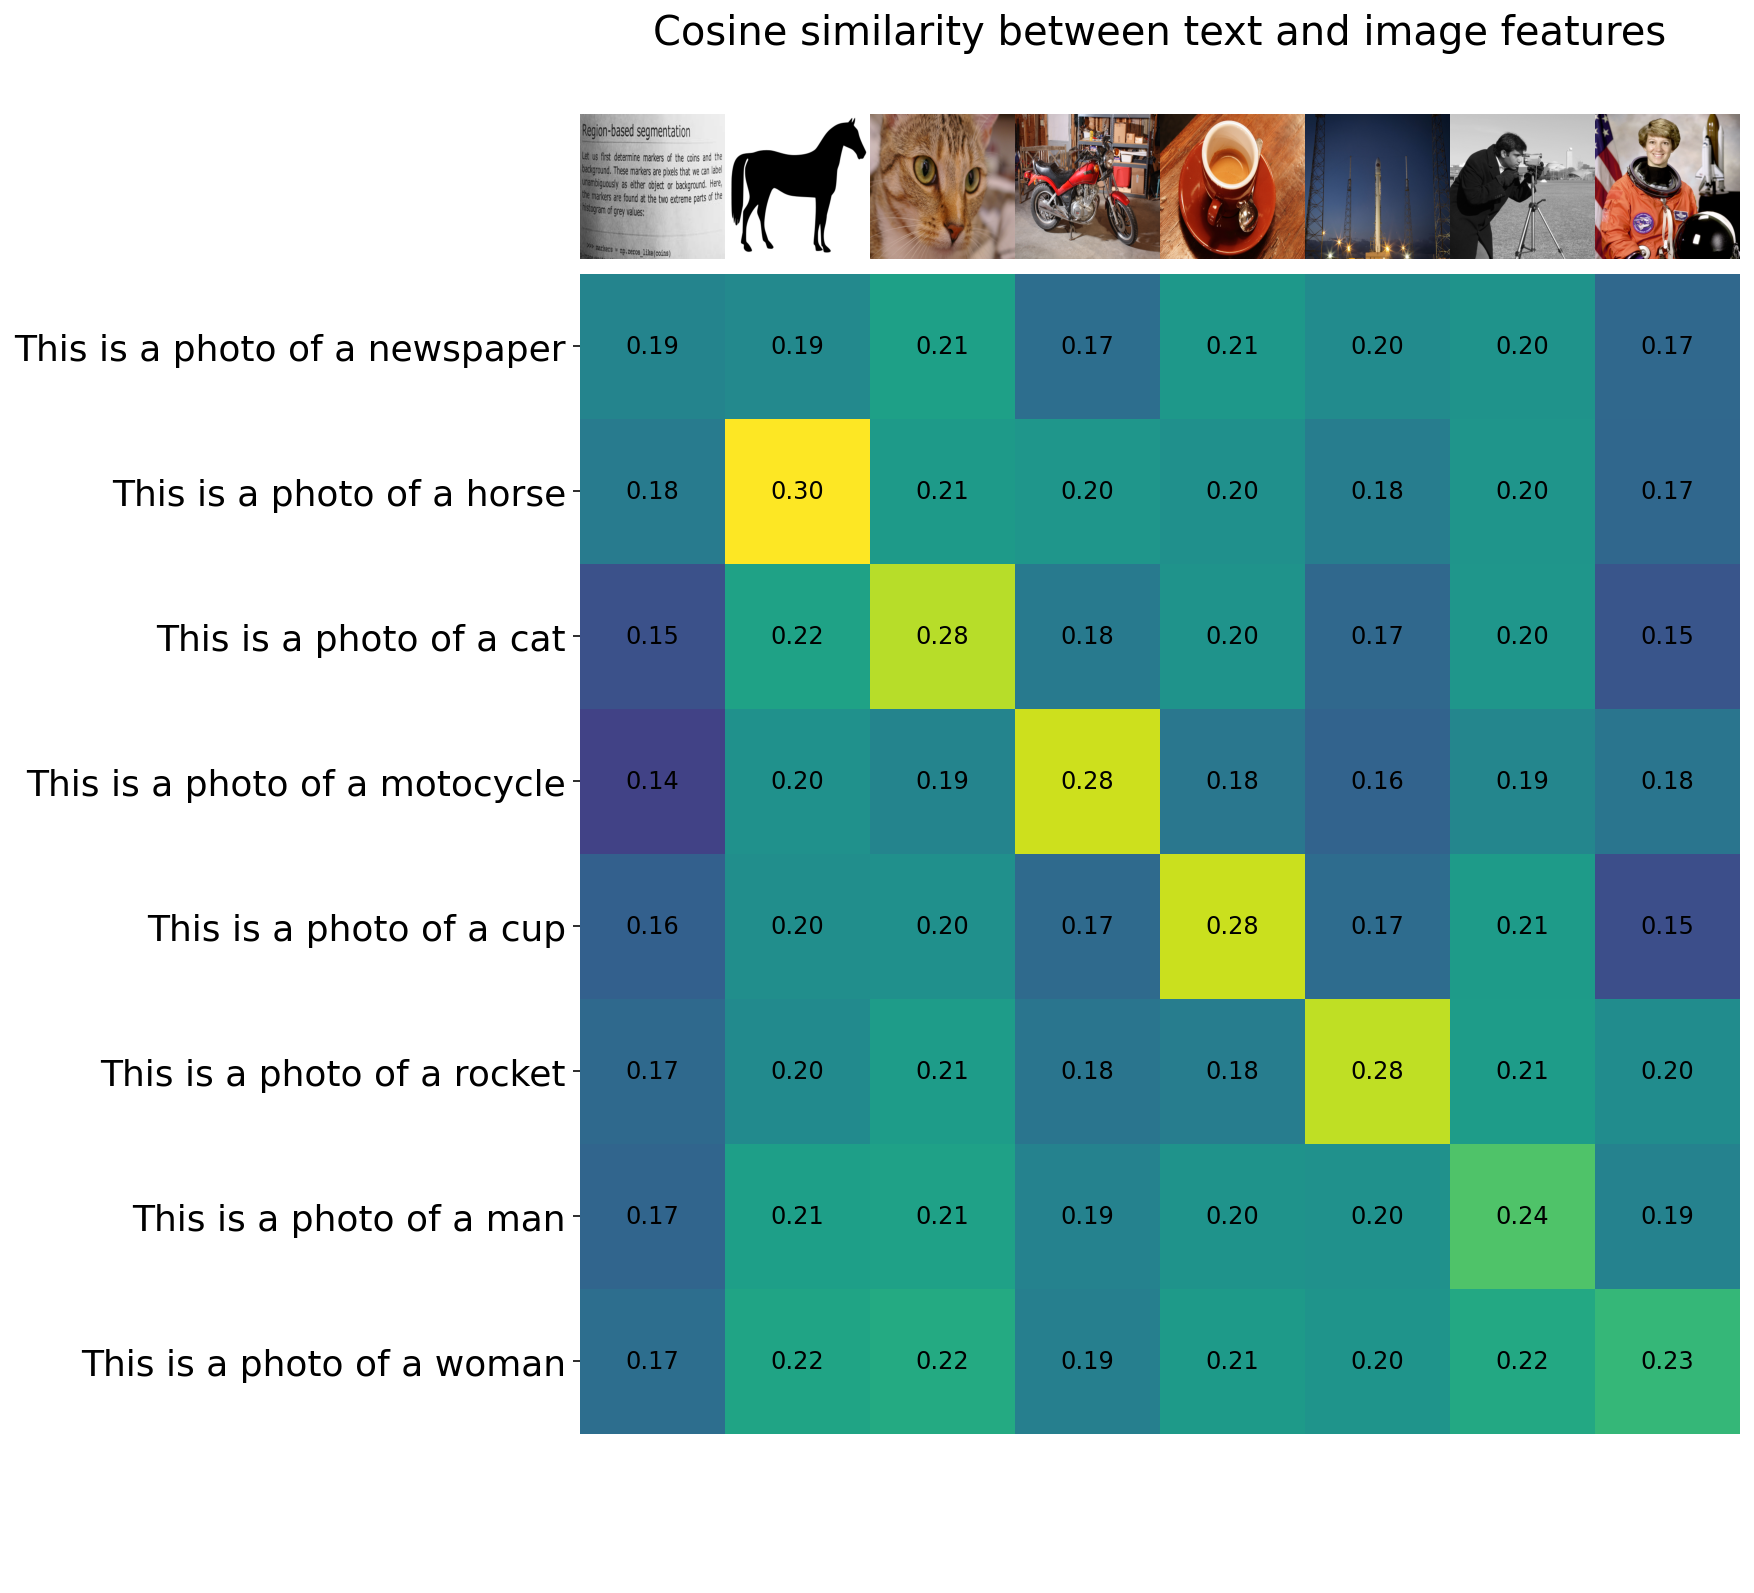

In [ ]:
similarity = (text_features @ image_features.T).cpu().numpy()
print(similarity)
plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# text_descriptions = [text_descriptions[i] for i in np.argmax(similarity, axis = 0)]
plt.yticks(range(count), text_descriptions, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower") # (left, right, bottom, top)
for x in range(similarity.shape[1]): 
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])
# plt.ylim([-2,count + 0.5])
plt.title("Cosine similarity between text and image features", size=20)


Text(0.5, 1.0, 'predicted Probability between text and image features')

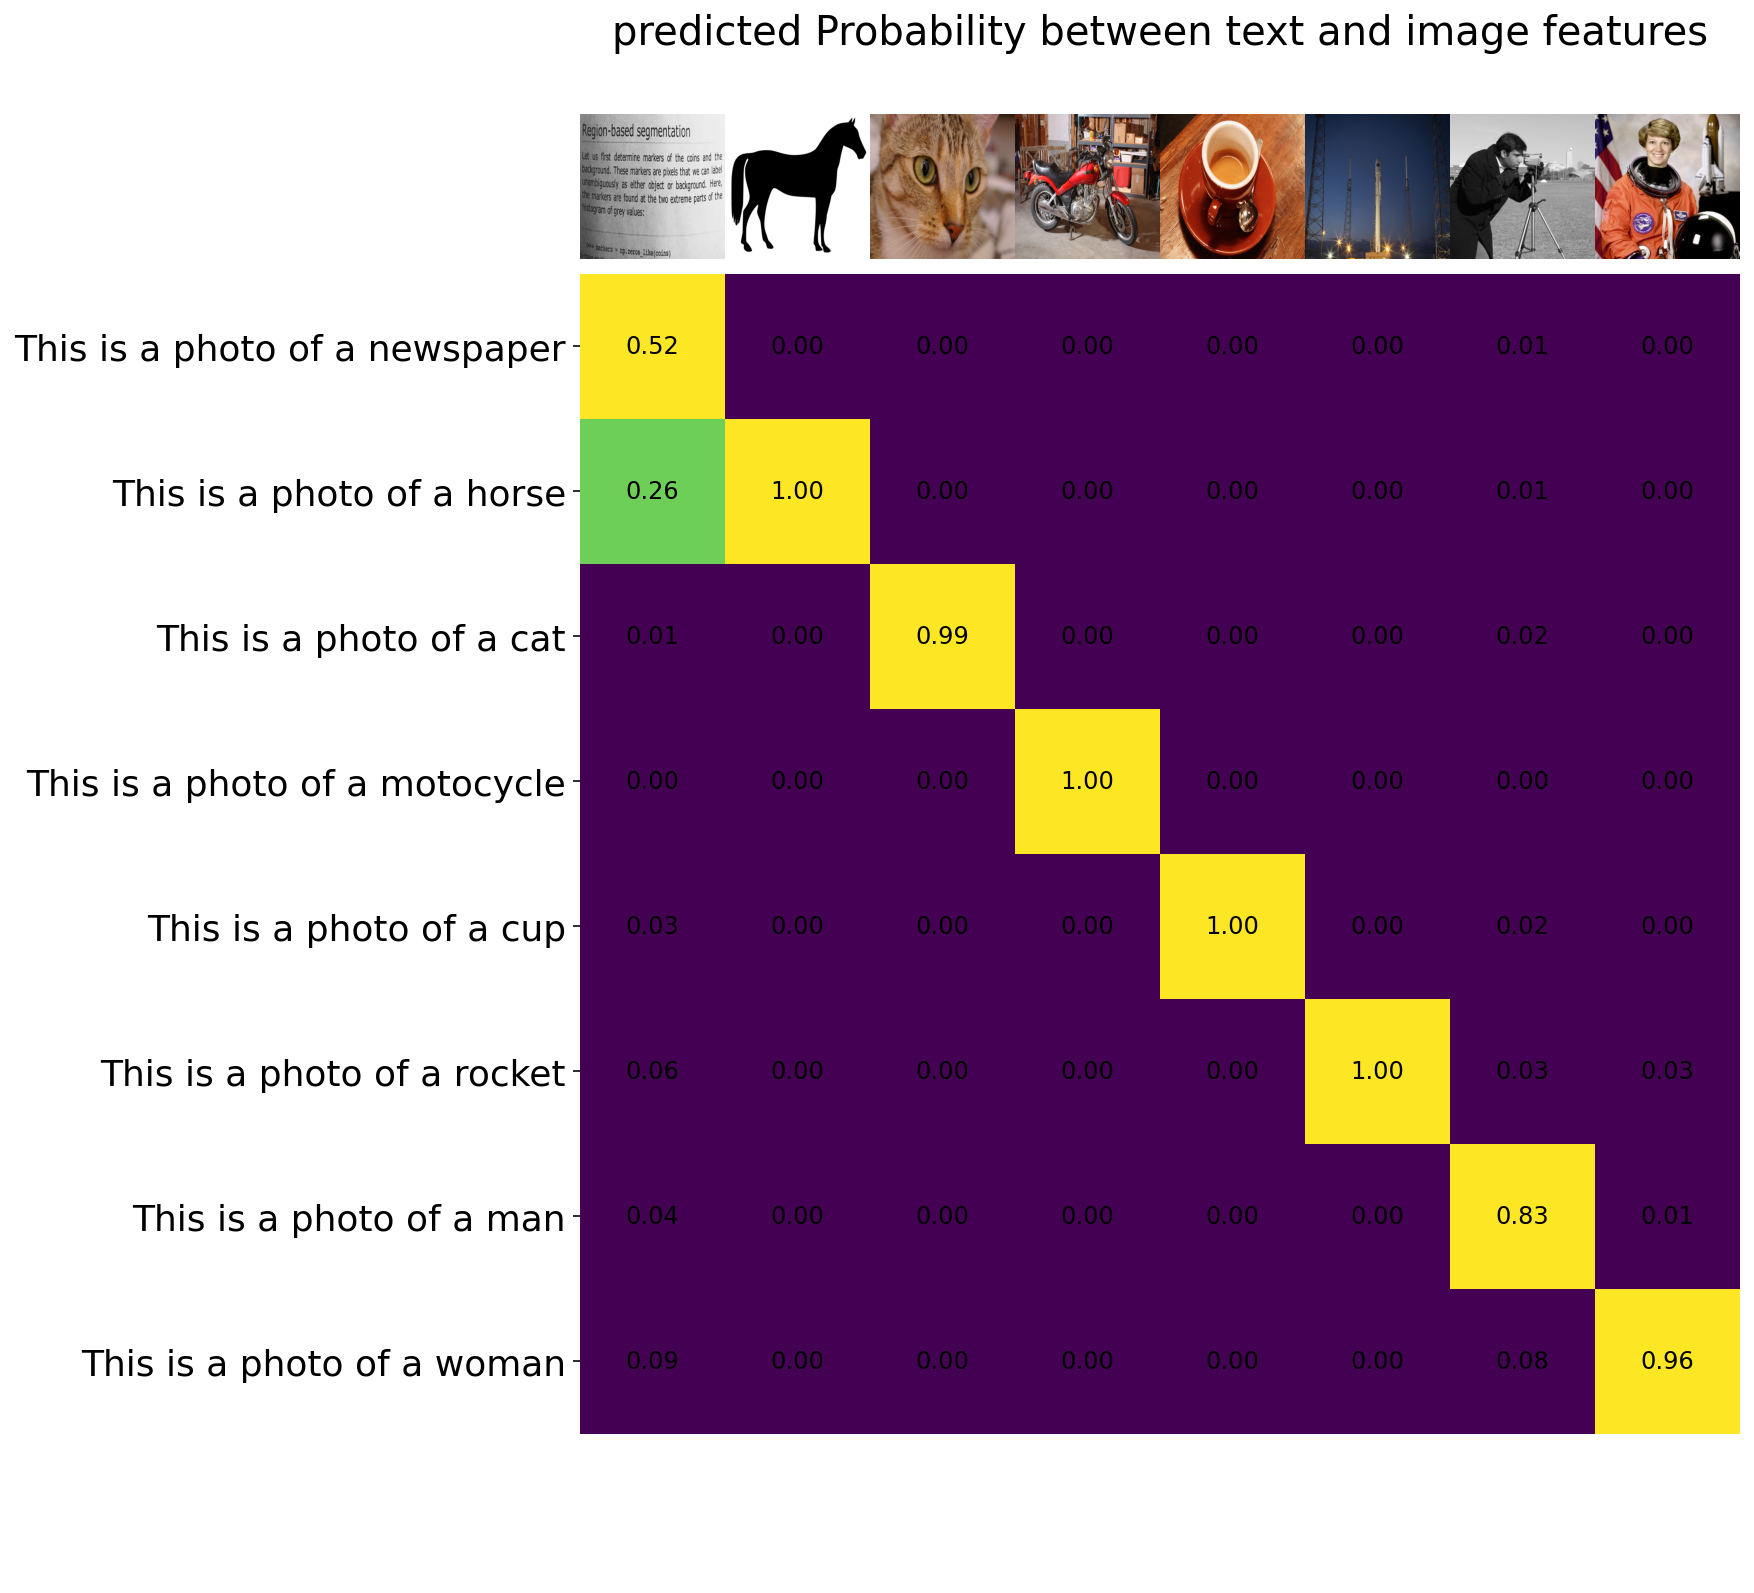

In [ ]:
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
similarity = text_probs.T.cpu().numpy()
plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
text_descriptions = [text_descriptions[i] for i in np.argmax(similarity, axis = 0)]
plt.yticks(range(count), text_descriptions, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower") # (left, right, bottom, top)
for x in range(similarity.shape[1]): 
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])
# plt.ylim([-2,count + 0.5])
plt.title("predicted Probability between text and image features", size=20)

**Zero-Shot Prediction**

The code below performs zero-shot prediction using CLIP, as shown in Appendix B in the paper. This example takes an image from the CIFAR-100 dataset, and predicts the most likely labels among the 100 textual labels from the dataset.



In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].flatten().float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def evaluate_classification(image_dataset_name, model, preprocess, device):

    data_dir = os.path.join('data',image_dataset_name)
    if image_dataset_name.startswith('cifar'):
      if image_dataset_name == 'cifar100':
          from torchvision.datasets import CIFAR100
          image_dataset = CIFAR100(data_dir, transform=preprocess, download=True, train=False)
      elif image_dataset_name == 'cifar10':
          from torchvision.datasets import CIFAR10
          image_dataset = CIFAR10(data_dir, transform=preprocess, download=True, train=False)
    dataloader = DataLoader(image_dataset, batch_size=100, shuffle=False, drop_last=True, num_workers=4)
    # tqdm_object = tqdm(dataloader, total=len(dataloader))

    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in image_dataset.classes]).to(device)

    top5, top1 = AverageMeter(), AverageMeter()
    with torch.no_grad():
      for (images, labels) in dataloader:
          # print(batch_idx)
          labels = labels.long().to(device)
          images = images.to(device)
          image_features = model.encode_image(images)
          text_features = model.encode_text(text_inputs)
          image_features /= image_features.norm(dim=-1, keepdim=True)
          text_features /= text_features.norm(dim=-1, keepdim=True)   
          # similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
          logits = image_features @ text_features.T
          _, pred = logits.topk(1, 1, True, True)
          pred = pred.t()
          precs = accuracy(logits, labels, topk=(1, 5))
          top1.update(precs[0].item(), images.size(0))
          top5.update(precs[1].item(), images.size(0))

    print("Classification on", image_dataset_name, top1.avg, top5.avg)

In [ ]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

image_dataset_name = 'cifar100'
# Download the dataset
# Prepare the inputs
evaluate_classification(image_dataset_name, model, preprocess, device)

Files already downloaded and verified


  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: ignored